# Project Overview

## OSEMN Pipeline

* O - Obtaining our data - in OS_dataset_cleanup
* S - Scrubbing/Cleaning our data - in OS_dataset_cleanup
* E - Exploring/Visualizing our data
* M - Modeling our data
* N - Interpreting the data

## Notebook Preparation

In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report,confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import xgboost as xgb


from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Load Cleaned File

In [2]:
combined = pd.read_pickle("data/final_flights_month01.pkl")

In [3]:
# Get Top 50 Overall Airports
top50 = list(combined['ORIGIN_AIRPORT_ID'].value_counts().nlargest(50).index)
final = combined[combined['ORIGIN_AIRPORT_ID'].isin(top50)].copy()

In [4]:
#top50.to_csv('data/weather/cities.csv')

In [5]:
final

,MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,DEP_DEL15,DISTANCE_GROUP,DEP_BLOCK,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,UNIQUE_CARRIER_NAME,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,LATITUDE,LONGITUDE
0,1,7,10397,"Atlanta, GA",0,1,AFTERNOON,1,280,50,Endeavor Air Inc.,0.00,0.0,0.0,69.0,43.0,6.49,33.641,-84.427
1,1,4,10397,"Atlanta, GA",0,2,AFTERNOON,1,251,50,Endeavor Air Inc.,0.15,0.0,0.0,55.0,51.0,5.37,33.641,-84.427
2,1,5,10397,"Atlanta, GA",1,1,LATE_NIGHT,1,135,50,Endeavor Air Inc.,1.44,0.0,0.0,66.0,45.0,12.08,33.641,-84.427
3,1,3,10397,"Atlanta, GA",1,1,EVENING,1,229,50,Endeavor Air Inc.,0.00,0.0,0.0,56.0,39.0,17.45,33.641,-84.427
4,1,7,10397,"Atlanta, GA",0,2,MIDDAY,1,172,50,Endeavor Air Inc.,0.00,0.0,0.0,69.0,43.0,6.49,33.641,-84.427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472878,1,3,12892,"Los Angeles, CA",1,10,LATE_NIGHT,1,88,276,United Air Lines Inc.,0.00,0.0,0.0,61.0,39.0,4.70,33.942,-118.408
472879,1,2,11618,"Newark, NJ",0,11,AFTERNOON,1,85,276,United Air Lines Inc.,0.08,0.0,0.0,58.0,40.0,14.99,40.696,-74.172
472880,1,2,12264,"Washington, DC",0,10,MORNING,1,59,219,United Air Lines Inc.,0.00,0.0,0.0,62.0,40.0,12.30,38.942,-77.458
472881,1,4,12266,"Houston, TX",0,7,EVENING,1,122,219,United Air Lines Inc.,0.14,0.0,0.0,59.0,46.0,8.72,29.983,-95.340


# Exploring/Visualizing Data

In [6]:
print('Raw counts: \n')
print(final['DEP_DEL15'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DEP_DEL15'].value_counts(normalize=True))

Raw counts: 

0    354814
1     76194
Name: DEP_DEL15, dtype: int64
-----------------------------------
Normalized counts: 

0    0.823219
1    0.176781
Name: DEP_DEL15, dtype: float64


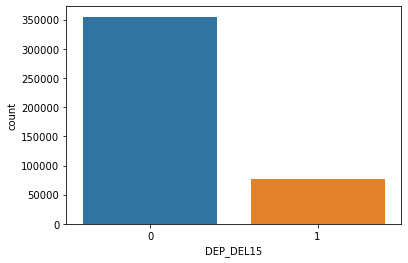

In [7]:
sns.countplot(x=final['DEP_DEL15'], data=final.drop('DEP_DEL15', axis=1))
plt.show()

In [8]:
final.groupby('DEP_DEL15').mean()

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,LATITUDE,LONGITUDE
DEP_DEL15,,,,,,,,,,,,
0,3.901385,1.272086,92.827236,136.137376,0.085448,0.071251,0.293448,51.561305,34.646798,8.408642,36.444296,-94.314149
1,3.915203,1.356367,94.430323,132.198375,0.153261,0.178950,0.613862,47.872825,31.566698,9.514946,36.916350,-92.362400


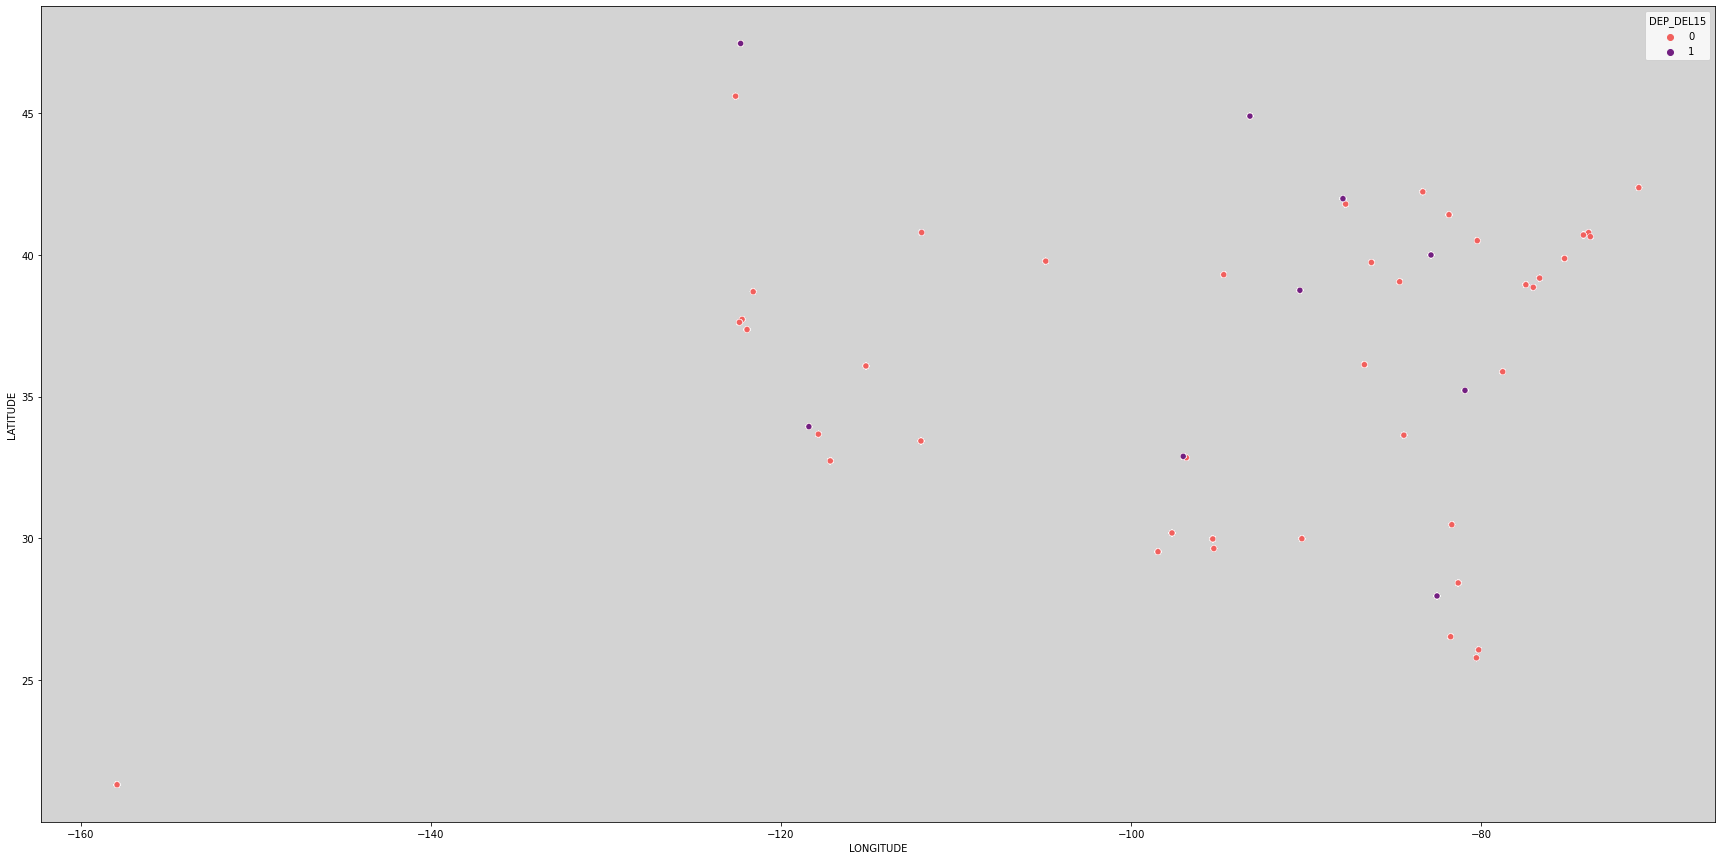

In [9]:
plt.figure(figsize=(30,15))
ax = plt.axes()
ax.set_facecolor("lightgrey")
sns.scale=2

sns.scatterplot(data=final, x="LONGITUDE", y="LATITUDE", hue="DEP_DEL15", palette="magma_r");

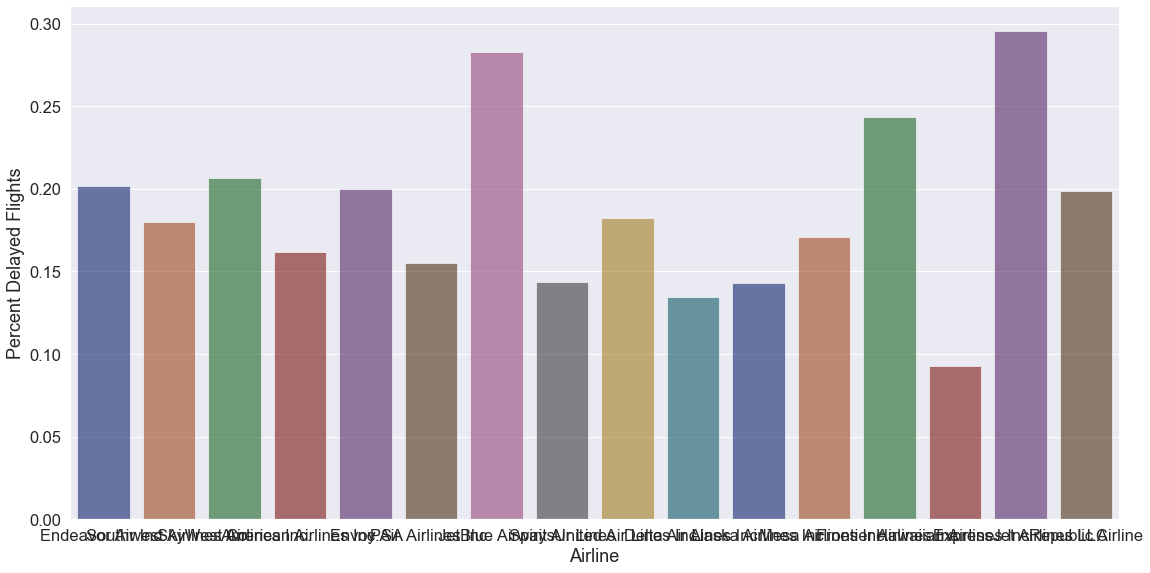

In [10]:
sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="UNIQUE_CARRIER_NAME", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airline", "Percent Delayed Flights");


In [13]:
final.groupby('UNIQUE_CARRIER_NAME').mean().sort_values('DEP_DEL15', ascending=False)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,LATITUDE,LONGITUDE
UNIQUE_CARRIER_NAME,,,,,,,,,,,,,
ExpressJet Airlines LLC,0.295551,2.192263,1.118762,105.958221,50.000000,0.080557,0.266770,1.398723,38.082012,23.132689,9.640058,39.538094,-84.540471
JetBlue Airways,0.282667,4.494235,1.003011,72.255188,133.352934,0.105657,0.048860,0.145625,50.934986,34.870292,10.184279,36.648864,-80.531792
Frontier Airlines Inc.,0.243735,4.832731,1.088478,78.441617,190.824335,0.092065,0.102609,0.238388,54.575691,35.132911,8.391714,35.179003,-93.610667
SkyWest Airlines Inc.,0.206493,2.670857,1.043753,105.656974,64.461576,0.079307,0.140301,0.596322,45.298535,29.299218,8.424402,38.861042,-100.780372
Endeavor Air Inc.,0.201933,2.508640,1.042612,106.573071,69.461341,0.111566,0.096156,0.349407,41.580612,26.174550,10.272727,38.792108,-81.370751
Envoy Air,0.199770,2.339932,1.102008,125.792096,54.907278,0.065145,0.123620,0.735836,44.343964,28.783889,9.947898,37.262658,-87.100964
Republic Airline,0.198818,2.840545,1.089910,84.621557,73.990135,0.093156,0.114031,0.462888,43.665609,27.515335,9.746727,38.103376,-81.458020
United Air Lines Inc.,0.182349,5.236683,1.136655,98.020628,158.932610,0.099222,0.125064,0.454190,51.151586,34.028936,8.660692,36.787770,-96.686820
Southwest Airlines Co.,0.179878,3.511964,1.942482,66.910012,152.387145,0.094764,0.078767,0.278987,54.059368,36.547633,7.922279,35.667601,-98.277507


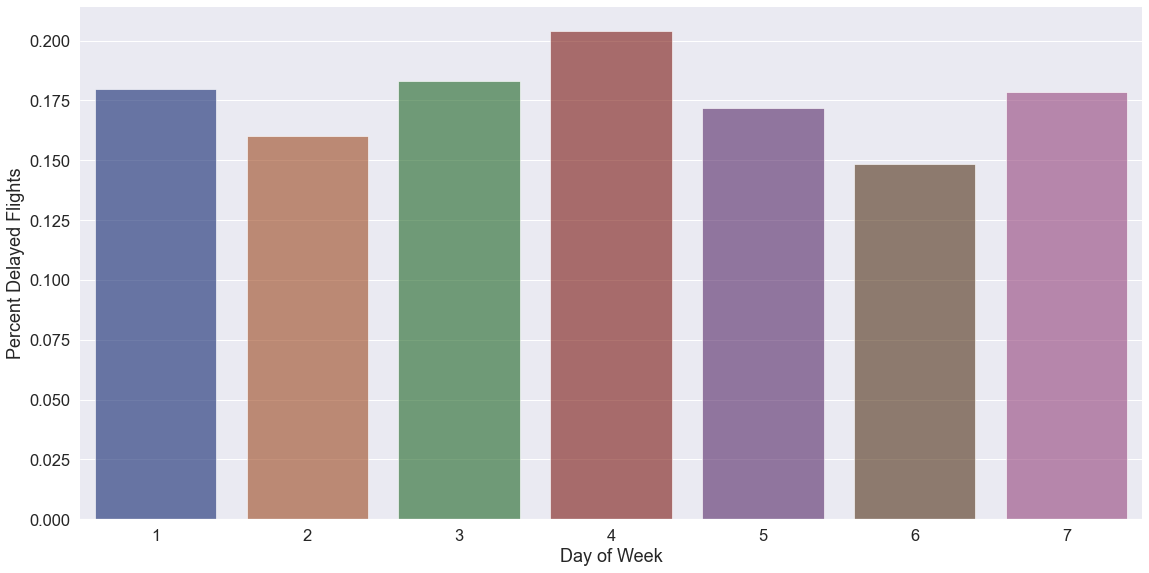

In [11]:
sns.set(font_scale = 1.5) #increasing our font size a bit


g = sns.catplot(
    data=final, kind="bar",
    x="DAY_OF_WEEK", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Day of Week", "Percent Delayed Flights");


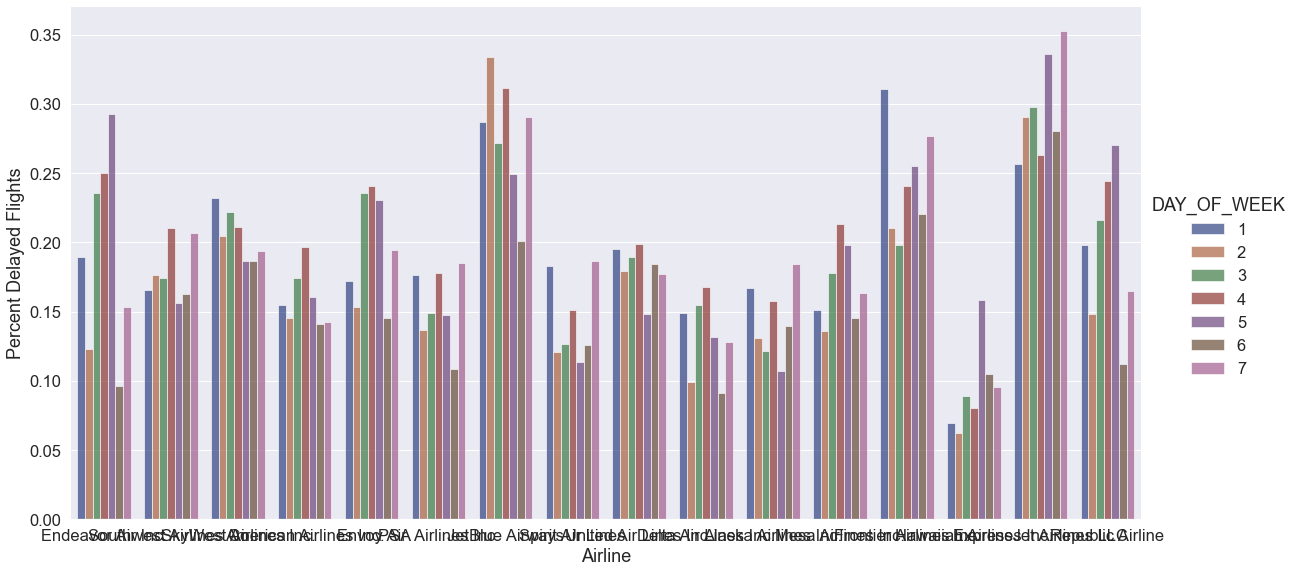

In [12]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="UNIQUE_CARRIER_NAME", y="DEP_DEL15", hue='DAY_OF_WEEK',
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airline", "Percent Delayed Flights");


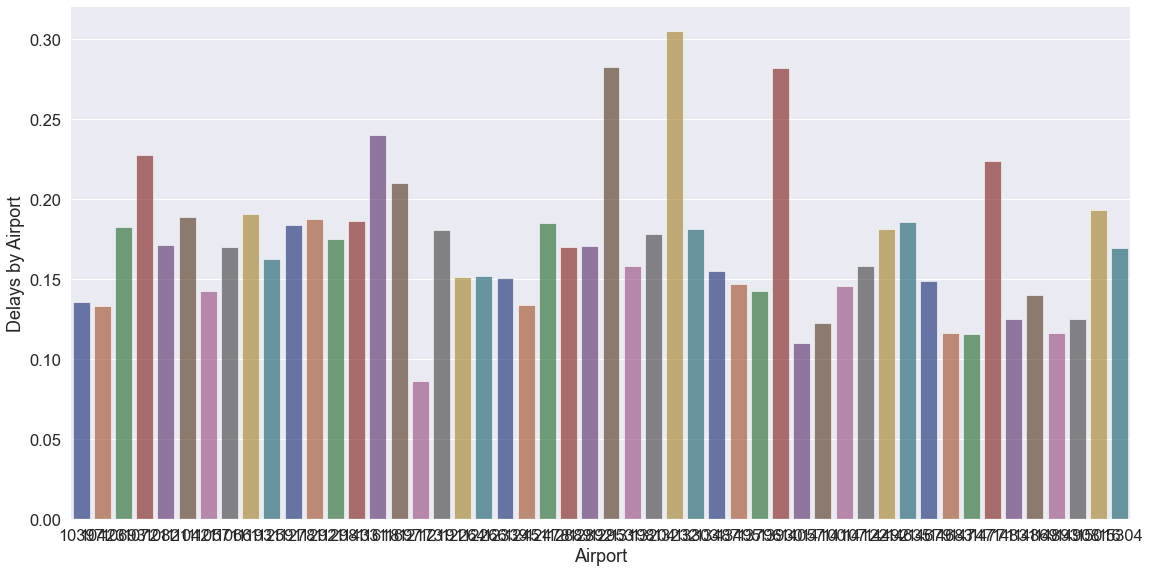

In [14]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="ORIGIN_AIRPORT_ID", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Airport", "Delays by Airport");


In [17]:
final.groupby('ORIGIN_CITY_NAME').mean().sort_values('DEP_DEL15', ascending=False)

,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,LATITUDE,LONGITUDE
ORIGIN_CITY_NAME,,,,,,,,,,,,,
"Chicago, IL",0.286812,3.534015,1.233010,148.363386,122.419226,0.052549,0.421835,2.354127,29.096557,16.847567,10.062012,41.939480,-87.875264
"New York, NY",0.242456,4.196863,1.056183,93.629625,116.208073,0.110059,0.021038,0.000000,39.345518,26.472684,13.026489,40.721062,-73.835030
"Newark, NJ",0.240216,5.080035,1.117517,78.862419,138.846654,0.109063,0.029313,0.000000,39.610958,24.475251,11.165354,40.696000,-74.172000
"Boston, MA",0.227463,4.182633,1.120359,80.692330,134.580840,0.085446,0.034500,0.000000,38.994055,23.546633,12.696535,42.364000,-71.006000
"San Francisco, CA",0.224042,5.167698,1.126871,91.839276,138.466891,0.131863,0.000000,0.000000,60.859729,48.808949,6.667746,37.619000,-122.375000
"Fort Lauderdale, FL",0.210212,4.505032,1.335818,61.586532,163.844453,0.138739,0.000000,0.000000,75.939868,60.550503,9.477828,26.074000,-80.152000
"St. Louis, MO",0.193588,3.567942,1.945812,38.745605,137.207446,0.087107,0.344943,1.080517,38.989452,23.335264,9.889866,38.747000,-90.364000
"Cincinnati, OH",0.190981,3.141344,1.233959,31.752724,99.429479,0.086964,0.000000,0.000000,38.800242,24.303269,7.850932,39.048000,-84.669000
"Cleveland, OH",0.189245,3.286096,1.304219,28.968509,115.799762,0.098800,0.418806,1.693939,35.301842,21.240939,12.033414,41.411000,-81.849000


In [ ]:
sns.set(font_scale = 1.5) #increasing our font size a bit

g = sns.catplot(
    data=final, kind="bar",
    x="MONTH", y="DEP_DEL15",
    ci=None, palette="dark", alpha=.6, height=8, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Month", "Delays by Month");


In [ ]:
final.groupby('MONTH').mean().sort_values('DEP_DEL15', ascending=False)

In [ ]:
final.dtypes

In [ ]:
final.drop(columns=['ORIGIN_CITY_NAME'], axis=1, inplace=True)
final.drop(columns=['ORIGIN_AIRPORT_ID'], axis=1, inplace=True)

## Train/Test Split

In [ ]:
randomstate = 42
testsize = .2

In [ ]:
# Define appropriate X and y

predictors = final.drop('DEP_DEL15', axis=1)
y = final['DEP_DEL15']

x_train, x_test, y_train, y_test = train_test_split(predictors, y, test_size=testsize, random_state=randomstate, stratify=y)

## Cleaning Pipelines

In [ ]:
features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

features_cat, cont_features

In [ ]:
def pipeline_fit_preprocessor(x):
    
    # Create a column transformer to one hot encode the categoricals
    print("Creating One-hot Transformer")
    cat_features_encoded = ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore"), features_cat)
        ], remainder="passthrough")

  
    # set up the preprocessing pipeline
    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('encoder', cat_features_encoded),
                ('scl', StandardScaler(with_mean=False)),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    return transformed_data, pipe
    # Label transformed data
    #print('Getting Labels')
    #encoder = cat_features_encoded.named_transformers_["ohe"]
    #object_labels0 = encoder.categories_[0] + '_' + features_cat[0]
    #object_labels1 = encoder.categories_[1] + '_' + features_cat[1]
    #print('Labeling features')
    #all_cols = list(object_labels0) + list(object_labels1) + cont_features
    #return pd.DataFrame(transformed_data, columns=all_cols, index=x.index)


def pipeline_transform_preprocessor(x, pipe):
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    return transformed_data
    
    # Label transformed data
    #print('Getting Labels')
    #encoder = cat_features_encoded.named_transformers_["ohe"]
    #object_labels0 = encoder.categories_[0] + '_' + features_cat[0]
    #object_labels1 = encoder.categories_[1] + '_' + features_cat[1]
    #print('Labeling features')
    #all_cols = list(object_labels0) + list(object_labels1) + cont_features
    #return pd.DataFrame(transformed_data, columns=all_cols, index=x.index)


In [ ]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_test = pipeline_transform_preprocessor(x_test, pipe)

In [ ]:
processed_train.shape

# Modeling

Model Plans:

* Basic Log Reg
* KNN
* Decision Tree
* Naive Bayes
* Random Forest
* XGBoost
* CatBoost

Feature Selection Plans:

* Basic Correlation
* RFECV
* Permutation Importance

Add Pipelines

In [ ]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['f1'] = []
models['accuracy'] = []

In [ ]:
def make_model(model, train, test, y_train, y_test, title):
    
    # fit model to train data
    model.fit(train, y_train)
    
    # get accuracy cross val score for cv 5
    cv_5 = cross_val_score(model, train, y_train, scoring='accuracy', cv=5)
    accs = round(cv_5.mean()*100,2)
    print("CV 5 Accuracy Train Score: {}".format(accs))
    
    # make predictions on test data
    preds = model.predict(test)
    
    # Print Testing accuracy
    print('\nTesting Accuracy: ', accuracy_score(y_test, preds))
    print('Testing f1 Score: ', f1_score(y_test, preds))
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    plot_confusion_matrix(model, test, y_test,
                     cmap=plt.cm.Blues)
    plt.show()
    
    # Get false positive, true positive, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    # print the AUC
    roc_auc = auc(fpr, tpr)
    print('\nAUC: {}'.format(auc(fpr, tpr)))

    # Visualize AUC
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    plt.figure(figsize=(15,10))
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Calculate our scores
    accuracy = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # append our results to our lists
    models['Models'].append(title)
    models['f1'].append(f1)
    models['accuracy'].append(accuracy)

In [ ]:
model = LogisticRegression(class_weight='balanced', random_state=randomstate, fit_intercept=False, C=1e12)

make_model(model, processed_train, processed_test, y_train, y_test, "Log Reg")

Fitting 5 folds for each of 128 candidates, totalling 640 fits
Best f1: 0.207
Best parameters set found on train set: 

{'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 10}


In [ ]:
smote = SMOTE()
processed_train_resampled, y_train_resampled = smote.fit_resample(processed_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts())


model = LogisticRegression(random_state=randomstate, fit_intercept=False, C=1e12)

make_model(model, processed_train, processed_test, y_train, y_test, "Log Reg SMOTE")

In [ ]:
model = DecisionTreeClassifier(criterion = 'gini', max_depth= 50, min_samples_leaf= 10, min_samples_split= 10)

make_model(model, processed_train, processed_test, y_train, y_test, "Decision Tree Classifier")

In [ ]:
# makes model and fits using optimal k
model = KNeighborsClassifier(n_neighbors = 1)

make_model(model, processed_train, processed_test, y_train, y_test, 'KNN')

In [ ]:
model = RandomForestClassifier(max_depth= 50, min_samples_leaf= 10, min_samples_split= 10)

make_model(model, processed_train, processed_test, y_train, y_test, "Random Forest Classifier")

In [ ]:
model = GradientBoostingClassifier()

make_model(model, processed_train, processed_test, y_train, y_test, "Gradient Boosting Classifier")

In [ ]:
model = xgb.XGBClassifier()

make_model(model, processed_train, processed_test, y_train, y_test, "XGBoost")

In [ ]:
chart = pd.DataFrame(models)
chart

## Estimator Helper Class

This code by David S. Bautista at http://www.davidsbatista.net/blog/2018/02/23/model_optimization/

In [ ]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=5, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
models1 = {
    'Logistic Regression': LogisticRegression(),
    #'KNN' : KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Naive Bayes Classifier' : GaussianNB(),
    #'Random Forest Classifier': RandomForestClassifier(),
    #'Extra Trees Classifier': ExtraTreesClassifier(),
    #'AdaBoost Classifier': AdaBoostClassifier(),
    #'Gradient Boosting Classifier': GradientBoostingClassifier(),
    #'SVC': SVC(),
    #'XGBoost' : xgb.XGBClassifier()
}

params1 = {
    
    'Logistic Regression': {'solver': ['liblinear', 'lbfgs']},
    #'KNN' : {'n_neighbors' : [1,5,10]},
    'Decision Tree Classifier' : {'criterion' : ['gini', 'entropy'], 'max_depth':[1,3,5,7]},
    'Naive Bayes Classifier' : {},
    #'RandomForestClassifier': { 'max_depth':[1,3,5,7] },    
    #'ExtraTreesClassifier': { 'max_depth':[1,3,5,7] },
    #'AdaBoostClassifier':  { 'max_depth':[1,3,5,7] },
    #'GradientBoostingClassifier': { 'max_depth':[1,3,5,7], 'learning_rate': [0.8, 1.0] },
    #'SVC': {'kernel': ['rbf', 'linear'], 'C': [1, 10], 'gamma': [0.001]},
    #'XGBoost' : {'max_depth':[1,3,5,7]},    
    
}

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(processed_train, y_train, scoring='accuracy', n_jobs=-1)

In [ ]:
helper1.score_summary(sort_by='max_score')

In [ ]:
# prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [ ]:
def make_model_log(model, train, test, y_train, y_test, title):
    
    model.fit(train, y_train)
    cv_5 = cross_val_score(model, train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    test_predictions = model.predict(test)
    
    # reverse log transform our predicted values
    test_predictions_unscaled = np.exp(test_predictions).astype(int)
    test_predictions_unscaled = test_predictions_unscaled.flatten()
    
    test_actual = np.exp(y_test)
    
    # get residuals
    residuals = test_actual - test_predictions_unscaled

    fig = plt.figure(figsize=(20,15))
    plt.scatter(test_predictions_unscaled, residuals)
    plt.show()
    
    # Calculate our errors
    mae = round(mean_absolute_error(test_actual, test_predictions_unscaled), 2)
    rmse = round(np.sqrt(mean_squared_error(test_actual, test_predictions_unscaled)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(train.shape[1]))

In [ ]:
print(classification_report(y_test, y_hat_test))

In [ ]:
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_hat_test)


# Import plot_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Visualize your confusion matrix
plot_confusion_matrix(logreg, x_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()


In [ ]:
# Fit SMOTE to training data
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

In [ ]:
# Instantiate the model
logreg = LogisticRegression(class_weight='balanced', fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model
logreg.fit(X_train_resampled, y_train_resampled)

# Predict
y_hat_test = logreg.predict(x_test)

y_score = logreg.decision_function(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
print('AUC: {}'.format( auc(fpr, tpr)))

In [ ]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat_test))

# Above and Beyond Plan

* Unit testing
* stacked ensemble model 
* 

## PCA

In [ ]:
pca_all = PCA(n_components=processed_train.shape[1], random_state=randomstate)
x_pca = pca_all.fit_transform(processed_train)

print("Explained variance with all components is ", sum(pca_all.explained_variance_ratio_ * 100))
print("1 component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[0])
print("1-2 principal component explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[1])
print("1-3 components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[2])
print("1-4 components explains ", np.cumsum(pca_all.explained_variance_ratio_ * 100)[3])

plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
#plt.savefig('images/pca.png')

In [ ]:
pca_2 = PCA(n_components=2, random_state=randomstate)
x_pca_2 = pca_2.fit_transform(processed_train)

print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=x_pca_2[:,0], y=x_pca_2[:,1], s=70, hue=y_train, palette=['green', 'blue'])
plt.title("2D Plot of 23% Variability")
plt.xlabel("First Component")
plt.ylabel("Second Component")

In [ ]:
pca_95th = PCA(n_components=.95, random_state=randomstate)
x_pca_95 = pca_95th.fit_transform(processed_train)

x_pca_95.shape

## MultiCollinearity

In [ ]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [ ]:
final.corr()

In [ ]:
#Get our list of highly correlated feature pairs with following steps:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 90% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


In [ ]:
# Check out our variables correlationg with price
df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_correlations.loc[df_correlations['level_0'] == 'DEP_DEL15'].sort_values(0, ascending=False)

# PARAMETER TUNING

In [ ]:
'''#Parameter Tuning

param_grid = {'criterion': ['gini', 'entropy'],
        'min_samples_leaf': [10, 50, 100, 1000],
        'max_depth': [5,10,25,50],
        'min_samples_split': [10, 50, 100, 1000],
        }

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid, verbose=10, scoring='f1', cv=5, n_jobs=-1)

grid_search.fit(processed_train, y_train)

grid_search.best_estimator_


# Best accuracy
print('Best f1: %.3f' % grid_search.best_score_)

print("Best parameters set found on train set: \n")
print(grid_search.best_params_)
print("\nGrid scores on train set:\n")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))'''

In [ ]:
'''
mae_val = [] #to store mae values for different k

# checks mean absolute error scores on k from 1 to 20
for K in range(20):
    K = K+1
    
    # set up the KNN regressor
    model = KNeighborsClassifier(n_neighbors = K)

    model.fit(processed_train, y_train)  #fit the model
    pred=model.predict(processed_test) #make prediction on test set
    error = accuracy_score(y_test,pred) #calculate accuracy
    f1 = f1_score(y_test,pred)
    mae_val.append(f1) #store mae values
    print('Accuracy value for k= ' , K , 'is:', error)
    print('F1 value for k= ' , K , 'is:', f1)
    
# gets optimal k-value based on score minimum
index_max = np.argmax(mae_val) + 1
'''


Accuracy value for k=  1 is: 0.7549476810282824
F1 value for k=  1 is: 0.2982992293382939
Accuracy value for k=  2 is: 0.8167443910814134
F1 value for k=  2 is: 0.17933399137617542
Accuracy value for k=  3 is: 0.7939838982854226
F1 value for k=  3 is: 0.2629591201494086
Accuracy value for k=  4 is: 0.818693301779541
F1 value for k=  4 is: 0.16756324900133157
Accuracy value for k=  5 is: 0.8084847219322058
F1 value for k=  5 is: 0.22858744918461757
Accuracy value for k=  6 is: 0.8200737801907149
F1 value for k=  6 is: 0.15449193196685565
Accuracy value for k=  7 is: 0.8126261571657271
F1 value for k=  7 is: 0.19721669980119283
Accuracy value for k=  8 is: 0.8213846546483841
F1 value for k=  8 is: 0.14026467139427104
Accuracy value for k=  9 is: 0.8168835989884226
F1 value for k=  9 is: 0.17773610459967704
Accuracy value for k=  10 is: 0.8221386974780167
F1 value for k=  10 is: 0.13054326868549393
Accuracy value for k=  11 is: 0.8190529222059812
F1 value for k=  11 is: 0.1599526066350711
Accuracy value for k=  12 is: 0.8227535324006403
F1 value for k=  12 is: 0.11778971072232808
Accuracy value for k=  13 is: 0.8203289946868982
F1 value for k=  13 is: 0.14525386313465782
Accuracy value for k=  14 is: 0.8227419317417229
F1 value for k=  14 is: 0.10810179780527666
Accuracy value for k=  15 is: 0.8209554302684392
F1 value for k=  15 is: 0.13008679968436476
Accuracy value for k=  16 is: 0.823124753485998
F1 value for k=  16 is: 0.10126731506041851
Accuracy value for k=  17 is: 0.821790677710494
F1 value for k=  17 is: 0.12297328157113496
Accuracy value for k=  18 is: 0.8234031693000162
F1 value for k=  18 is: 0.09370720962076562
Accuracy value for k=  19 is: 0.8224751165866221
F1 value for k=  19 is: 0.11261235140620468
Accuracy value for k=  20 is: 0.8232523607340897
F1 value for k=  20 is: 0.08711803475134812

# DEPRECATED

In [ ]:
df.drop(df.loc[df['DEP_TIME'].isna()].index, axis=0, inplace=True)
df.drop(df.loc[df['TAIL_NUM'].isna()].index, axis=0, inplace=True)
df.drop(df.loc[df['CANCELLED']==1].index, axis=0, inplace=True)

In [ ]:
df.loc[(df['DEP_TIME_BLK']=='2100-2159') | (df['DEP_TIME_BLK']=='2200-2259') | (df['DEP_TIME_BLK']=='2300-2359'), 'DEP_BLOCK'] = 'LATE_NIGHT'

df.loc[(df['DEP_TIME_BLK']=='0001-0559'), 'DEP_BLOCK'] = 'EARLY_MORNING'
       
df.loc[(df['DEP_TIME_BLK']=='0600-0659') | (df['DEP_TIME_BLK']=='0700-0759') | (df['DEP_TIME_BLK']=='0800-0859') | (df['DEP_TIME_BLK']=='0900-0959'), 'DEP_BLOCK'] = 'MORNING'

df.loc[(df['DEP_TIME_BLK']=='1000-1059') | (df['DEP_TIME_BLK']=='1100-1159') | (df['DEP_TIME_BLK']=='1200-1259'), 'DEP_BLOCK'] = 'MIDDAY'

df.loc[(df['DEP_TIME_BLK']=='1300-1359') | (df['DEP_TIME_BLK']=='1400-1459') | (df['DEP_TIME_BLK']=='1500-1559') | (df['DEP_TIME_BLK']=='1600-1659'), 'DEP_BLOCK'] = 'AFTERNOON'

df.loc[(df['DEP_TIME_BLK']=='1700-1759') | (df['DEP_TIME_BLK']=='1800-1859') | (df['DEP_TIME_BLK']=='1900-1959') | (df['DEP_TIME_BLK']=='2000-2059') , 'DEP_BLOCK'] = 'EVENING'


In [ ]:
df

In [ ]:
df.drop(columns = ['MONTH', 'ORIGIN',  'DEST',  
                   'CRS_DEP_TIME', 'DEP_DELAY_NEW', 'CRS_ARR_TIME', 'ARR_TIME', 
                   'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'DISTANCE',
                   'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
                  'ARR_DELAY_NEW', 'Unnamed: 32', 'DEP_TIME_BLK', 'ARR_TIME_BLK', 'ACTUAL_ELAPSED_TIME',
                  'DEST_AIRPORT_ID', 'DEST_CITY_NAME'],
        axis=1, inplace=True)

In [ ]:
df.memory_usage().sum()

In [ ]:
df.dtypes

In [ ]:
df['DAY_OF_MONTH'] = df['DAY_OF_MONTH'].astype('int8')
df['DAY_OF_WEEK'] = df['DAY_OF_WEEK'].astype('object')
df['OP_CARRIER_FL_NUM'] = df['OP_CARRIER_FL_NUM'].astype('object')
#df['ORIGIN_AIRPORT_ID'] = df['ORIGIN_AIRPORT_ID'].astype('object')
#df['DEST_AIRPORT_ID'] = df['DEST_AIRPORT_ID'].astype('object')
df['DEP_DEL15'] = df['DEP_DEL15'].astype('int8')
df['DISTANCE_GROUP'] = df['DISTANCE_GROUP'].astype('int8')

#### Flight Sequence Order

In [ ]:
carriers = list(df['OP_UNIQUE_CARRIER'].unique())
days = list(df['DAY_OF_MONTH'].unique())
flight_nums = list(df['OP_CARRIER_FL_NUM'].unique())

# TEMP STUFF
#carriers = ['WN']
#days = [1]

In [ ]:
# apply sequence order to same-day flight number sequences

for carrier in carriers:
    print("Working on Carrier: {}".format(carrier))
    for day in days:
        print("Carrier {} Day {}".format(carrier, day))
        flights = df.loc[(df['OP_UNIQUE_CARRIER'] == carrier) & 
                  (df['DAY_OF_MONTH'] == day), 'OP_CARRIER_FL_NUM'].unique()
        print(flights)
        for flight in flights:
            sequence = df.loc[(df['OP_UNIQUE_CARRIER'] == carrier) & 
                  (df['DAY_OF_MONTH'] == day) & (df['OP_CARRIER_FL_NUM'] == flight)]
            df.loc[(df['OP_UNIQUE_CARRIER'] == carrier) & 
                  (df['DAY_OF_MONTH'] == day) & (df['OP_CARRIER_FL_NUM'] == flight), 
                      'sequence_rank'] = sequence['DEP_TIME'].rank()

            
df.loc[(df['OP_UNIQUE_CARRIER'] == carrier) & (df['DAY_OF_MONTH'] == day)]                     

#### Airplane Seat Count

In [ ]:
# Drop unneeded columns. All we need is the Tail Number and the number of seats
aircraft.drop(columns=['MANUFACTURER', 'MODEL', 'Unnamed: 4'], axis=1, inplace=True)

# Merge aircraft info with main frame on tail number
final = df.merge(aircraft, how="inner", left_on='TAIL_NUM', right_on='TAIL_NUMBER')

# drop any entries that didn't match to a tail number
final.drop(columns=['TAIL_NUM', 'TAIL_NUMBER'], axis=1, inplace=True)

# simplify data type of number of seats to reduce memory usage
final['NUMBER_OF_SEATS'] = final['NUMBER_OF_SEATS'].astype('int16')

final

#### Concurrent Flights

In [ ]:
def find_flights(line):
    origin = line['ORIGIN_AIRPORT_ID']
    day = line['DAY_OF_MONTH']
    block = line['DEP_BLOCK']
    flights = airport_business.loc[(airport_business['ORIGIN_AIRPORT_ID'] == origin) & 
                                    (airport_business['DAY_OF_MONTH'] == day) & 
                                   (airport_business['DEP_BLOCK'] == block), ['FLIGHTS_IN_BLOCK']]
    number = flights.iloc[0]
    return number

In [ ]:
final['CONCURRENT_FLIGHTS'] = 0
final['CONCURRENT_FLIGHTS'] = final.apply(lambda x: find_flights(x), axis=1)

#### Airport Coordinates

In [ ]:
# make a copy of the original df to do the coordinates EDA

df_with_coords = final

df_with_coords['ORIGIN_LAT'] = 0
df_with_coords['ORIGIN_LONG'] = 0

In [ ]:
for item in coords_dict:
    airport = item['AIRPORT_ID']
    lat = item['LATITUDE']
    long = item['LONGITUDE']
    df_with_coords.loc[df_with_coords['ORIGIN_AIRPORT_ID']==airport, 'ORIGIN_LAT'] = lat
    df_with_coords.loc[df_with_coords['ORIGIN_AIRPORT_ID']==airport, 'ORIGIN_LONG'] = long

#### Flight Sequencing

In [ ]:
    # List flight sequence for daily flight segments
    print("\n\nStarting Flight Sequencing...")
    carriers = list(monthly_data['OP_UNIQUE_CARRIER'].unique())
    days = list(monthly_data['DAY_OF_MONTH'].unique())
    flight_nums = list(monthly_data['OP_CARRIER_FL_NUM'].unique())
    
    for carrier in carriers:
        print("\nWorking on Carrier: {}\n".format(carrier))
        flights = monthly_data.loc[(monthly_data['OP_UNIQUE_CARRIER'] == carrier), 'OP_CARRIER_FL_NUM'].unique()
        print(flights)
        for day in days:
            print(f'\nElapsed Time: {time.time() - start}')
            print("Carrier {} Day {}".format(carrier, day)) 
            for flight in flights:
                try:
                    sequence = monthly_data.loc[(monthly_data['OP_UNIQUE_CARRIER'] == carrier) & 
                          (monthly_data['DAY_OF_MONTH'] == day) & (monthly_data['OP_CARRIER_FL_NUM'] == flight)]
                    monthly_data.loc[(monthly_data['OP_UNIQUE_CARRIER'] == carrier) & 
                          (monthly_data['DAY_OF_MONTH'] == day) & (monthly_data['OP_CARRIER_FL_NUM'] == flight), 
                              'sequence_rank'] = sequence['DEP_TIME'].rank()
                except:
                    continue